# Importing Dependencies

In [1]:
import tensorflow as tf

In [2]:
import sys
print(sys.version)


3.9.18 (main, Sep 11 2023, 14:09:26) [MSC v.1916 64 bit (AMD64)]


In [3]:
tf.__version__

'2.10.0'

In [4]:
print(tf.test.is_gpu_available())


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


In [5]:
print(tf.test.is_built_with_cuda())

True


In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import nltk
import re
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from tensorflow.keras.callbacks import LearningRateScheduler
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.layers import Dense ,GlobalAveragePooling1D, Embedding , Flatten
from sklearn.model_selection import train_test_split 
from nltk.corpus import stopwords


In [8]:
data = pd.read_csv('Corona_NLP_train.csv', encoding = 'latin-1')

In [9]:
data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


<Axes: xlabel='Sentiment', ylabel='count'>

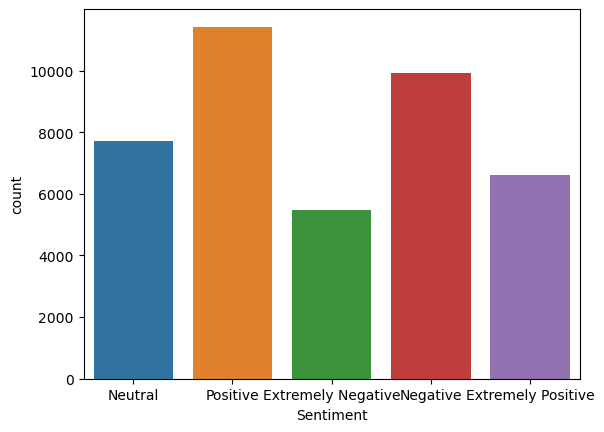

In [10]:
sns.countplot(x ='Sentiment', data = data )

In [11]:
data.isnull().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [12]:
data.shape

(41157, 6)

In [13]:
data.isnull().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [14]:
data['OriginalTweet'][0]

'@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8'

As we can see that the data contains unwanted tags which can ne a problem for Neural Networks, so we have to remove them


# Data Preproceessing

In [15]:
data = data[['OriginalTweet','Sentiment']]

In [16]:
data.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [17]:
data.tail()

,OriginalTweet,Sentiment
41152,Airline pilots offering to stock supermarket s...,Neutral
41153,Response to complaint not provided citing COVI...,Extremely Negative
41154,You know itÂs getting tough when @KameronWild...,Positive
41155,Is it wrong that the smell of hand sanitizer i...,Neutral
41156,@TartiiCat Well new/used Rift S are going for ...,Negative


In [18]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\MIR
[nltk_data]     FAISAL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
def preprocess_text(text):
    text.lower()
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\S+', '', text)  # Remove mentions
    text = re.sub(r'#', '', text)  # Remove hashtags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphanumeric characters
    text = re.sub('[^a-zA-Z]', ' ', text) # Remove punctuations and numbers
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*') #Removing stopwords
    text = pattern.sub('', text)
    return text

In [20]:
data['cleaned tweets'] = data['OriginalTweet'].apply(preprocess_text)

In [21]:
sentiment_mapping = {'Neutral': 2, 'Positive': 1,'Negative': 0, 'Extremely Positive': 3,'Extremely Negative': 4}

In [22]:
data['Sentiment'] = data['Sentiment'].replace(sentiment_mapping)

In [23]:
data.head(15)

,OriginalTweet,Sentiment,cleaned tweets
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,2,
1,advice Talk to your neighbours family to excha...,1,advice Talk neighbours family exchange phone n...
2,Coronavirus Australia: Woolworths to give elde...,1,Coronavirus Australia Woolworths give elderly ...
3,My food stock is not the only one which is emp...,1,My food stock one empty PLEASE dont panic...
4,"Me, ready to go at supermarket during the #COV...",4,Me ready go supermarket COVID outbreak No...
5,As news of the regionÂs first confirmed COVID...,1,As news regions first confirmed COVID case cam...
6,Cashier at grocery store was sharing his insig...,1,Cashier grocery store sharing insights Covid T...
7,Was at the supermarket today. Didn't buy toile...,2,Was supermarket today Didnt buy toilet paper R...
8,Due to COVID-19 our retail store and classroom...,1,Due COVID retail store classroom Atlanta open ...
9,"For corona prevention,we should stop to buy th...",0,For corona preventionwe stop buy things cash u...


In [24]:
X_train= data['cleaned tweets']

In [25]:
data['cleaned tweets'][7]

'Was supermarket today Didnt buy toilet paper Rebel      toiletpapercrisis covid '

In [26]:
y_train = data['Sentiment']
y_train[0]

2

# Preparing Test Data

In [27]:
data2 = pd.read_csv('Corona_NLP_test.csv',encoding = 'latin-1')

In [28]:
data2.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [29]:
data2['cleaned tweets'] = data2['OriginalTweet'].apply(preprocess_text)

In [30]:
data2['Sentiment'] = data2['Sentiment'].replace(sentiment_mapping)

In [31]:
data2.isnull().sum()

UserName            0
ScreenName          0
Location          834
TweetAt             0
OriginalTweet       0
Sentiment           0
cleaned tweets      0
dtype: int64

In [32]:
data2.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,cleaned tweets
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,4,TRENDING New Yorkers encounter empty supermark...
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,1,When I couldnt find hand sanitizer Fred Meyer ...
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,3,Find protect loved ones coronavirus
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,0,Panic buying hits NewYork City anxious shopper...
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,2,toiletpaper dunnypaper coronavirus coronavirus...


In [33]:
data2['cleaned tweets'][3]

'Panic buying hits NewYork City anxious shoppers stock foodampmedical supplies healthcare worker becomes BigApple st confirmed coronavirus patient OR Bloomberg staged event            QAnon QAnon QAnon    Election CDC '

In [34]:
data2 = data2[['cleaned tweets','Sentiment']]
data2.head()

,cleaned tweets,Sentiment
0,TRENDING New Yorkers encounter empty supermark...,4
1,When I couldnt find hand sanitizer Fred Meyer ...,1
2,Find protect loved ones coronavirus,3
3,Panic buying hits NewYork City anxious shopper...,0
4,toiletpaper dunnypaper coronavirus coronavirus...,2


In [35]:
X_test = data2['cleaned tweets']
y_test = data2['Sentiment']

# Preparing Embedding Layer

In [36]:
#Tokenizing each tweet
tokenizer = Tokenizer()
tokenized_text = tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [37]:
#padding all tweets to fixed lengths
max_len = 50
X_train = pad_sequences(X_train, padding = 'post', maxlen = max_len)
X_test = pad_sequences(X_test, padding = 'post', maxlen = max_len)


# Model Info


In [38]:
X_train.dtype

dtype('int32')

In [39]:
X_train = X_train.astype(np.float64)
X_train.dtype

dtype('float64')

In [40]:
X_train

array([[0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [4.3900e+02, 8.2500e+02, 2.4900e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [2.0000e+00, 7.2800e+02, 3.1120e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       ...,
       [6.3000e+01, 6.4000e+01, 1.5800e+02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.9700e+02, 6.5500e+02, 4.1510e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.2000e+02, 4.8001e+04, 4.8002e+04, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]])

In [41]:
y_train.value_counts()

Sentiment
1    11422
0     9917
2     7713
3     6624
4     5481
Name: count, dtype: int64

In [42]:
y_train.info()

<class 'pandas.core.series.Series'>
RangeIndex: 41157 entries, 0 to 41156
Series name: Sentiment
Non-Null Count  Dtype
--------------  -----
41157 non-null  int64
dtypes: int64(1)
memory usage: 321.7 KB


In [43]:
y_train.dtype

dtype('int64')

In [44]:
y_train = y_train.astype(np.int64)
y_train.dtype

dtype('int64')

In [45]:
y_train

0        2
1        1
2        1
3        1
4        4
        ..
41152    2
41153    4
41154    1
41155    2
41156    0
Name: Sentiment, Length: 41157, dtype: int64

In [46]:
#from tensorflow.keras.utils import to_categorical
#y_train_categorical = to_categorical(y_train)
#y_train_categorical.dtype

# Model Training


## Hyperparameter Tuning

In [47]:
num_classes = 5
def create_model(reg_strength,units,learning_rate,decay):
    model = Sequential()
    
    model.add(Embedding(input_dim=50000, output_dim=100, input_length=max_len))
    
    model.add(GlobalAveragePooling1D())
    
    model.add(Flatten())
    
    model.add(Dense(units=units, activation='relu', kernel_regularizer=l2(reg_strength)))
    
    model.add(Dense(units=num_classes, activation='softmax', kernel_regularizer=l2(reg_strength)))
    
    optimizer =tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate, decay=decay)
    
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [48]:
model = KerasClassifier(model=create_model,learning_rate=0.01,decay=0.0,units=64,reg_strength=0.01, verbose=1)

In [49]:
model.get_params().keys()

dict_keys(['model', 'build_fn', 'warm_start', 'random_state', 'optimizer', 'loss', 'metrics', 'batch_size', 'validation_batch_size', 'verbose', 'callbacks', 'validation_split', 'shuffle', 'run_eagerly', 'epochs', 'learning_rate', 'decay', 'units', 'reg_strength', 'class_weight'])

In [50]:
params = {
    'model__learning_rate': [0.0001, 0.001, 0.01, 0.1],
    'model__decay': [0.0, 1e-6, 1e-2,1e-8],
    'model__units': [16,64,100,120],   
    'model__reg_strength': [0.001, 0.01, 0.09 , 0.1],
    
    #'model__hidden_layers': [1, 2, 3],
    #'batch_size': [32, 64, 128],   
    #'epochs': [10, 15, 20],
}

In [51]:
grid = GridSearchCV(estimator=model, param_grid=params,scoring='accuracy',cv=3,verbose =2 )
grid.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__model', 'estimator__build_fn', 'estimator__warm_start', 'estimator__random_state', 'estimator__optimizer', 'estimator__loss', 'estimator__metrics', 'estimator__batch_size', 'estimator__validation_batch_size', 'estimator__verbose', 'estimator__callbacks', 'estimator__validation_split', 'estimator__shuffle', 'estimator__run_eagerly', 'estimator__epochs', 'estimator__learning_rate', 'estimator__decay', 'estimator__units', 'estimator__reg_strength', 'estimator__class_weight', 'estimator', 'n_jobs', 'param_grid', 'pre_dispatch', 'refit', 'return_train_score', 'scoring', 'verbose'])

In [52]:
grid_result = grid.fit(X_train, y_train)
print(f"Best accuracy: {grid_result.best_score_} using {grid_result.best_params_}")

Fitting 3 folds for each of 256 candidates, totalling 768 fits
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=0.0, model__learning_rate=0.0001, model__reg_strength=0.001, model__units=16; total time=   7.6s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=0.0, model__learning_rate=0.0001, model__reg_strength=0.001, model__units=16; total time=   6.3s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=0.0, model__learning_rate=0.0001, model__reg_strength=0.001, model__units=16; total time=   6.4s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=0.0, model__learning_rate=0.0001, model__reg_strength=0.001, model__units=64; total time=   6.4s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=0.0, model__learning_rate=0.0001, model__reg_strength=0.001, model__units=64; total time=   6.3s
429/429 [==============================] - 1s 1ms/step
[CV] END mod

429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=0.0, model__learning_rate=0.0001, model__reg_strength=0.09, model__units=100; total time=   6.8s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=0.0, model__learning_rate=0.0001, model__reg_strength=0.09, model__units=100; total time=   6.5s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=0.0, model__learning_rate=0.0001, model__reg_strength=0.09, model__units=120; total time=   6.4s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=0.0, model__learning_rate=0.0001, model__reg_strength=0.09, model__units=120; total time=   6.2s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=0.0, model__learning_rate=0.0001, model__reg_strength=0.09, model__units=120; total time=   6.2s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=0.0, model__learning_rate=0.0001, model__reg_strength

429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=0.0, model__learning_rate=0.001, model__reg_strength=0.01, model__units=16; total time=   6.2s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=0.0, model__learning_rate=0.001, model__reg_strength=0.01, model__units=64; total time=   6.2s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=0.0, model__learning_rate=0.001, model__reg_strength=0.01, model__units=64; total time=   6.1s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=0.0, model__learning_rate=0.001, model__reg_strength=0.01, model__units=64; total time=   6.2s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=0.0, model__learning_rate=0.001, model__reg_strength=0.01, model__units=100; total time=   6.2s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=0.0, model__learning_rate=0.001, model__reg_strength=0.01, mod

429/429 [==============================] - 1s 2ms/step
[CV] END model__decay=0.0, model__learning_rate=0.001, model__reg_strength=0.1, model__units=120; total time=   6.7s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=0.0, model__learning_rate=0.001, model__reg_strength=0.1, model__units=120; total time=   7.0s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=0.0, model__learning_rate=0.001, model__reg_strength=0.1, model__units=120; total time=   6.4s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=0.0, model__learning_rate=0.01, model__reg_strength=0.001, model__units=16; total time=   6.7s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=0.0, model__learning_rate=0.01, model__reg_strength=0.001, model__units=16; total time=   6.8s
429/429 [==============================] - 1s 2ms/step
[CV] END model__decay=0.0, model__learning_rate=0.01, model__reg_strength=0.001, mode

429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=0.0, model__learning_rate=0.01, model__reg_strength=0.09, model__units=64; total time=   7.0s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=0.0, model__learning_rate=0.01, model__reg_strength=0.09, model__units=100; total time=   6.9s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=0.0, model__learning_rate=0.01, model__reg_strength=0.09, model__units=100; total time=   6.9s
429/429 [==============================] - 1s 2ms/step
[CV] END model__decay=0.0, model__learning_rate=0.01, model__reg_strength=0.09, model__units=100; total time=   7.0s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=0.0, model__learning_rate=0.01, model__reg_strength=0.09, model__units=120; total time=   7.0s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=0.0, model__learning_rate=0.01, model__reg_strength=0.09, model_

429/429 [==============================] - 1s 2ms/step
[CV] END model__decay=0.0, model__learning_rate=0.1, model__reg_strength=0.01, model__units=16; total time=   7.3s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=0.0, model__learning_rate=0.1, model__reg_strength=0.01, model__units=16; total time=   6.9s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=0.0, model__learning_rate=0.1, model__reg_strength=0.01, model__units=16; total time=   6.9s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=0.0, model__learning_rate=0.1, model__reg_strength=0.01, model__units=64; total time=   7.0s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=0.0, model__learning_rate=0.1, model__reg_strength=0.01, model__units=64; total time=   6.9s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=0.0, model__learning_rate=0.1, model__reg_strength=0.01, model__units=64;

429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=0.0, model__learning_rate=0.1, model__reg_strength=0.1, model__units=100; total time=   7.0s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=0.0, model__learning_rate=0.1, model__reg_strength=0.1, model__units=120; total time=   7.0s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=0.0, model__learning_rate=0.1, model__reg_strength=0.1, model__units=120; total time=   7.0s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=0.0, model__learning_rate=0.1, model__reg_strength=0.1, model__units=120; total time=   6.9s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=1e-06, model__learning_rate=0.0001, model__reg_strength=0.001, model__units=16; total time=   7.1s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=1e-06, model__learning_rate=0.0001, model__reg_strength=0.001, mode

429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=1e-06, model__learning_rate=0.0001, model__reg_strength=0.09, model__units=64; total time=   7.3s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=1e-06, model__learning_rate=0.0001, model__reg_strength=0.09, model__units=64; total time=   6.9s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=1e-06, model__learning_rate=0.0001, model__reg_strength=0.09, model__units=64; total time=   7.0s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=1e-06, model__learning_rate=0.0001, model__reg_strength=0.09, model__units=100; total time=   6.9s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=1e-06, model__learning_rate=0.0001, model__reg_strength=0.09, model__units=100; total time=   7.0s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=1e-06, model__learning_rate=0.0001, model__reg

429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=1e-06, model__learning_rate=0.001, model__reg_strength=0.001, model__units=120; total time=   7.0s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=1e-06, model__learning_rate=0.001, model__reg_strength=0.001, model__units=120; total time=   6.9s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=1e-06, model__learning_rate=0.001, model__reg_strength=0.01, model__units=16; total time=   6.9s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=1e-06, model__learning_rate=0.001, model__reg_strength=0.01, model__units=16; total time=   7.0s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=1e-06, model__learning_rate=0.001, model__reg_strength=0.01, model__units=16; total time=   7.0s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=1e-06, model__learning_rate=0.001, model__reg_str

429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=1e-06, model__learning_rate=0.001, model__reg_strength=0.1, model__units=64; total time=   7.0s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=1e-06, model__learning_rate=0.001, model__reg_strength=0.1, model__units=100; total time=   7.0s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=1e-06, model__learning_rate=0.001, model__reg_strength=0.1, model__units=100; total time=   7.0s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=1e-06, model__learning_rate=0.001, model__reg_strength=0.1, model__units=100; total time=   6.9s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=1e-06, model__learning_rate=0.001, model__reg_strength=0.1, model__units=120; total time=   6.9s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=1e-06, model__learning_rate=0.001, model__reg_strength

429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=1e-06, model__learning_rate=0.01, model__reg_strength=0.09, model__units=16; total time=   7.0s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=1e-06, model__learning_rate=0.01, model__reg_strength=0.09, model__units=16; total time=   7.3s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=1e-06, model__learning_rate=0.01, model__reg_strength=0.09, model__units=16; total time=   7.2s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=1e-06, model__learning_rate=0.01, model__reg_strength=0.09, model__units=64; total time=   7.0s
429/429 [==============================] - 1s 2ms/step
[CV] END model__decay=1e-06, model__learning_rate=0.01, model__reg_strength=0.09, model__units=64; total time=   7.3s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=1e-06, model__learning_rate=0.01, model__reg_strength=0.09

429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=1e-06, model__learning_rate=0.1, model__reg_strength=0.001, model__units=100; total time=   6.9s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=1e-06, model__learning_rate=0.1, model__reg_strength=0.001, model__units=100; total time=   7.0s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=1e-06, model__learning_rate=0.1, model__reg_strength=0.001, model__units=120; total time=   6.9s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=1e-06, model__learning_rate=0.1, model__reg_strength=0.001, model__units=120; total time=   7.0s
429/429 [==============================] - 1s 2ms/step
[CV] END model__decay=1e-06, model__learning_rate=0.1, model__reg_strength=0.001, model__units=120; total time=   7.0s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=1e-06, model__learning_rate=0.1, model__reg_strength=

429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=1e-06, model__learning_rate=0.1, model__reg_strength=0.1, model__units=16; total time=   7.0s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=1e-06, model__learning_rate=0.1, model__reg_strength=0.1, model__units=64; total time=   6.9s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=1e-06, model__learning_rate=0.1, model__reg_strength=0.1, model__units=64; total time=   7.0s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=1e-06, model__learning_rate=0.1, model__reg_strength=0.1, model__units=64; total time=   7.0s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=1e-06, model__learning_rate=0.1, model__reg_strength=0.1, model__units=100; total time=   7.2s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=1e-06, model__learning_rate=0.1, model__reg_strength=0.1, model__un

429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=0.01, model__learning_rate=0.0001, model__reg_strength=0.01, model__units=120; total time=   6.9s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=0.01, model__learning_rate=0.0001, model__reg_strength=0.01, model__units=120; total time=   7.0s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=0.01, model__learning_rate=0.0001, model__reg_strength=0.01, model__units=120; total time=   6.9s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=0.01, model__learning_rate=0.0001, model__reg_strength=0.09, model__units=16; total time=   6.9s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=0.01, model__learning_rate=0.0001, model__reg_strength=0.09, model__units=16; total time=   6.9s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=0.01, model__learning_rate=0.0001, model__reg_stre

429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=0.01, model__learning_rate=0.001, model__reg_strength=0.001, model__units=64; total time=   6.9s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=0.01, model__learning_rate=0.001, model__reg_strength=0.001, model__units=64; total time=   6.9s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=0.01, model__learning_rate=0.001, model__reg_strength=0.001, model__units=100; total time=   6.9s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=0.01, model__learning_rate=0.001, model__reg_strength=0.001, model__units=100; total time=   7.2s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=0.01, model__learning_rate=0.001, model__reg_strength=0.001, model__units=100; total time=   6.9s
429/429 [==============================] - 1s 2ms/step
[CV] END model__decay=0.01, model__learning_rate=0.001, model__reg_stren

429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=0.01, model__learning_rate=0.001, model__reg_strength=0.09, model__units=120; total time=   6.9s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=0.01, model__learning_rate=0.001, model__reg_strength=0.1, model__units=16; total time=   7.0s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=0.01, model__learning_rate=0.001, model__reg_strength=0.1, model__units=16; total time=   7.0s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=0.01, model__learning_rate=0.001, model__reg_strength=0.1, model__units=16; total time=   6.9s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=0.01, model__learning_rate=0.001, model__reg_strength=0.1, model__units=64; total time=   7.0s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=0.01, model__learning_rate=0.001, model__reg_strength=0.1, mo

429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=0.01, model__learning_rate=0.01, model__reg_strength=0.01, model__units=100; total time=   7.0s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=0.01, model__learning_rate=0.01, model__reg_strength=0.01, model__units=100; total time=   6.9s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=0.01, model__learning_rate=0.01, model__reg_strength=0.01, model__units=100; total time=   7.2s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=0.01, model__learning_rate=0.01, model__reg_strength=0.01, model__units=120; total time=   6.9s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=0.01, model__learning_rate=0.01, model__reg_strength=0.01, model__units=120; total time=   7.0s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=0.01, model__learning_rate=0.01, model__reg_strength=0.01,

429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=0.01, model__learning_rate=0.1, model__reg_strength=0.001, model__units=16; total time=   7.0s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=0.01, model__learning_rate=0.1, model__reg_strength=0.001, model__units=16; total time=   7.0s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=0.01, model__learning_rate=0.1, model__reg_strength=0.001, model__units=64; total time=   6.9s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=0.01, model__learning_rate=0.1, model__reg_strength=0.001, model__units=64; total time=   7.0s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=0.01, model__learning_rate=0.1, model__reg_strength=0.001, model__units=64; total time=   7.0s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=0.01, model__learning_rate=0.1, model__reg_strength=0.001, mode

429/429 [==============================] - 1s 2ms/step
[CV] END model__decay=0.01, model__learning_rate=0.1, model__reg_strength=0.09, model__units=120; total time=   7.2s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=0.01, model__learning_rate=0.1, model__reg_strength=0.09, model__units=120; total time=   6.9s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=0.01, model__learning_rate=0.1, model__reg_strength=0.09, model__units=120; total time=   6.9s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=0.01, model__learning_rate=0.1, model__reg_strength=0.1, model__units=16; total time=   6.9s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=0.01, model__learning_rate=0.1, model__reg_strength=0.1, model__units=16; total time=   6.9s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=0.01, model__learning_rate=0.1, model__reg_strength=0.1, model__uni

429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=1e-08, model__learning_rate=0.0001, model__reg_strength=0.01, model__units=64; total time=   7.0s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=1e-08, model__learning_rate=0.0001, model__reg_strength=0.01, model__units=64; total time=   6.9s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=1e-08, model__learning_rate=0.0001, model__reg_strength=0.01, model__units=100; total time=   7.0s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=1e-08, model__learning_rate=0.0001, model__reg_strength=0.01, model__units=100; total time=   7.0s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=1e-08, model__learning_rate=0.0001, model__reg_strength=0.01, model__units=100; total time=   7.0s
429/429 [==============================] - 1s 1ms/step
[CV] END model__decay=1e-08, model__learning_rate=0.0001, model__re

KeyboardInterrupt: 

In [ ]:
#model_history = model.fit(X_train, y_train, batch_size = 128,epochs = 10, verbose = 1,validation_split = 0.2)

In [ ]:
#score = model.evaluate(X_test, y_test, verbose=1)

In [ ]:
#print("Test Score:", score[0])
#print("Test Accuracy:", score[1])

In [ ]:
'''plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy') 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train','test'],loc = 'upper left')
plt.show()'''

In [ ]:
'''plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend(['train','test'], loc = 'upper left')
plt.show'''

In [ ]:
#prediction = model.predict(X_test)

In [ ]:
'''tweet = "Amazing news! Researchers just announced a breakthrough in the search for a COVID-19 vaccine. There's hope on the horizon! 🌟 #VaccineHope #CovidBreakthrough"
tokenized_review = tokenizer.texts_to_sequences([tweet])
padded_tweet = pad_sequences(tokenized_review, maxlen=50)'''


In [ ]:
#pred = model.predict(padded_tweet)
#print(pred)

In [ ]:
#predicted_class_index = np.argmax(pred)
#print(predicted_class_index)

In [ ]:
#for key, value in sentiment_mapping.items():
    #if value == predicted_class_index:
        #print(f"The predicted sentiment is: {key}")
    